## Brief Introduction

The evolutional equation of Heston model is

$dS(t)= r S(t)dt + \sqrt{v_t}S(t)dW_1(t), dv(t)=k(m-v(t))dt+\sigma\sqrt{v_t}dW_2(t)$.

Here $W_1,W_2$ are negatively correlated Wiener processes. The implementation could be referred to *The Volatility Surface* by Jim Gatheral.

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import tqdm

In [2]:
# parameters

S_0 = 100 # spot price
v_0 = 0.01 # initial variance

r = 0.1 # avg return
rho = -0.2 # correlation of two Wiener processes
k = 2 # mean-reverting rate
m = 0.04 # mean variance
sigma = 0.05 # vol of vol

T = 1 # total time, in year
N = 250*20 # number of steps
epochs = 10000 # number of paths

strike = 100 # strike price
barrier = 120 # barrier price
in_out = 'out' # up-in or up-out

## Generating paths

In [3]:
def generating_path(epochs=epochs, S_0=S_0, v_0=v_0, r=r, rho=rho, k=k, m=m, sigma=sigma, T=T, N=N):
    dt = T/N
    dt_root = np.sqrt(dt)

    # if antithetic method is needed, take the inverse of rvs and add it to the end of original rvs. this will generate additional epochs paths. 
    rvs = ss.multivariate_normal.rvs(mean=[0,0],cov=[[1,rho],[rho,1]],size=(epochs, N-1))

    Paths = np.zeros((epochs, N))
    Vars = np.zeros((epochs, N))    
    Paths[:,0] = S_0
    Vars[:,0] = v_0
    W_1 = rvs[:,:,0]
    W_2 = rvs[:,:,1]
    for i in range(N-1):
        Vars[:,i+1] = Vars[:,i] + k*(m-Vars[:,i])*dt + sigma*np.sqrt(Vars[:,i])*W_2[:,i]*dt_root
        Vars[:,i+1] = np.maximum(Vars[:,i+1],0) # absorbing. can be replaced by reflection if the variance is negative.
        Paths[:,i+1] = Paths[:,i] + r*Paths[:,i]*dt + np.sqrt(Vars[:,i])*Paths[:,i]*W_1[:,i]*dt_root
    return Paths

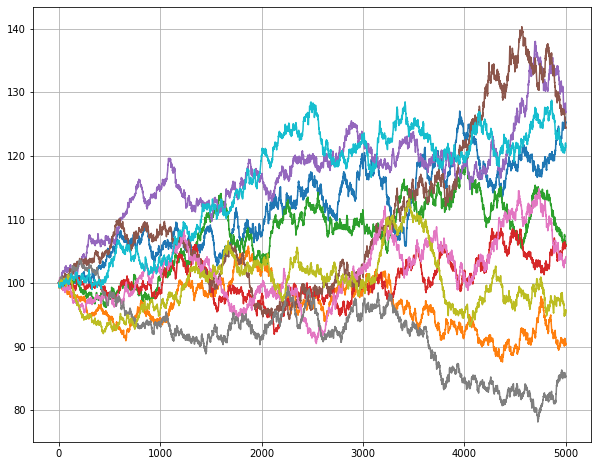

In [4]:
# picture of 10 paths

example = generating_path(epochs=10)
plt.figure(figsize=(10,8))
plt.grid()
plt.plot(example.T)

## Pricing

In [5]:
def pay_off(ar, strike=strike, barrier=barrier, state = in_out):
    # pay-off of a knock-out option along a single path
    ar_max = np.max(ar)
    ret = 0
    if state == 'in' and ar_max >= barrier:
        ret = max(ar[-1]-strike, 0)
    elif state == 'out' and ar_max <= barrier:
        ret = max(ar[-1]-strike, 0)
    return ret

In [6]:
def MC_pricing(epochs=epochs, S_0=S_0, v_0=v_0, r=r, rho=rho, k=k, m=m, sigma=sigma, T=T, N=N, strike=strike, barrier=barrier, state = in_out): 
    # return the discounted price
    ret = 0
    Paths = generating_path(epochs=epochs, S_0=S_0, v_0=v_0, r=r, rho=rho, k=k, m=m, sigma=sigma, T=T, N=N)
    for p in Paths:
        ret += pay_off(ar=p, strike=strike, barrier=barrier, state = in_out)
    return np.exp(-r*T)*ret/epochs

In [7]:
%%time
MC_pricing(epochs=epochs)

CPU times: user 24.6 s, sys: 2.05 s, total: 26.6 s
Wall time: 29.4 s


1.7432738318106251